In [2]:
import numpy as np

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/grading_tests')
from helpers import *
from implementations import *

In [ ]:
import os
os.getcwd()

'/Users/gladys/Desktop/project1/grading_tests'

In [4]:
# loading the data
data_path = '/content/drive/MyDrive/Colab Notebooks/data/dataset_to_release'
x_train_preclean, x_test_preclean, y_train, train_ids, test_ids = load_csv_data(data_path, sub_sample=True)

# Getting an idea of the data

In [5]:
print("X train", x_train_preclean.shape)
print("X test", x_test_preclean.shape)

X train (6563, 321)
X test (109379, 321)


Text(0, 0.5, '# of columns')

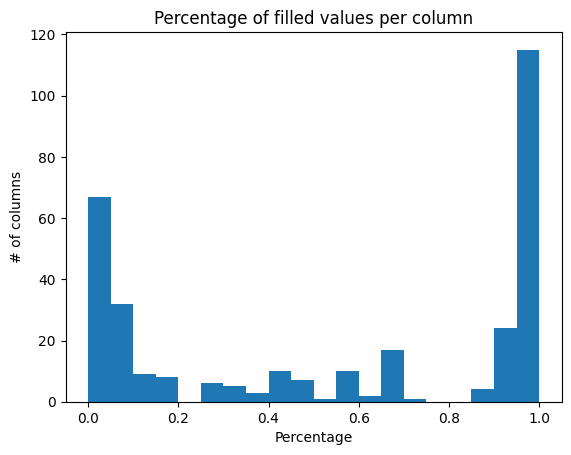

In [7]:
## Find how many values are completely empty in column
import matplotlib.pyplot as plt

def percentageFilled(data):
    return 1 - np.isnan(data).sum() / len(data)

percentage_filled = np.apply_along_axis(percentageFilled, 0, x_train_preclean)

plt.hist(percentage_filled, bins=20)
plt.title("Percentage of filled values per column")
plt.xlabel("Percentage")
plt.ylabel("# of columns")

# Data Cleaning

In [8]:
## Process data
## 1. drop the columns with more than 80% missing values
def threshold_col_filter(data, threshold):
    """
    filter out data where the column has less than threshold percentage of data
    returns:
        indicies of columns to keep
    """
    percentage_filled = np.apply_along_axis(percentageFilled, 0, data)
    # keep_indicies = np.argwhere(percentage_filled > threshold).flatten()
    return percentage_filled > threshold


def non_constant_filter(data):
    """
    filter out where the values in the column are all the same
    """
    return np.logical_not(np.logical_or(np.isnan(np.nanstd(data, 0)), np.nanstd(data, 0) == 0))

# TODO uncorrelation?


# TODO correlation w
## SEE LATER, done at a later stage, after these two steps


keep_indicies = np.argwhere(np.logical_and(
    threshold_col_filter(x_train_preclean, 0.2),
    non_constant_filter(x_train_preclean))
).flatten()


In [9]:
def standardize(x):
    """Standardize the original data set."""
    std = np.nanstd(x, axis=0)
    mean = np.nanmean(x, axis=0)
    return np.nan_to_num((x - np.nanmean(x, axis=0)) / np.nanstd(x, axis=0)), mean, std

In [10]:
def transform_train(feature):
    m = dict()
    for x in feature:
        if x not in m:
            m[x] = len(m)
    f = np.vstack((np.eye(len(m)), np.zeros(len(m))))
    u = f[np.vectorize(lambda key: m.get(key, len(m)))(feature)]
    return u, m


def transform_test(feature, m):
    n_uniq = len(m)
    f = np.vstack((np.eye(n_uniq), np.zeros(n_uniq)))
    ind = np.array([m[k] if k in m else n_uniq for k in feature])
    return f[ind]

In [62]:
def process_train(data, corr_threshold = 0.5, cat_threshold = 10, verbose = False):
    n, m = data.shape
    filter = np.logical_and(threshold_col_filter(data, 0.2), non_constant_filter(data))
    categorical_filter = np.apply_along_axis(lambda x: len(set(x)) < cat_threshold, 0, data)
    cat_transform = dict()
    num_transform = dict()
    features = np.empty((n, 0))
    transform_log = list()
    cnt = 0
    for i in range(m):
        if not filter[i]:
            transform_log.append(f"{i} deleted")
            cnt += 1
            continue
        if categorical_filter[i]:
            encoded, mp = transform_train(data[:, i])
            l = encoded.shape[1]
            transform_log.append(f"{i} cat exp: {cnt}-{cnt + l - 1}")
            cnt += l
            cat_transform[i] = mp
            features = np.append(features, encoded, axis=1)
        else:
            transform_log.append(f"{i} num: {cnt}")
            cnt += 1
            x_num_std, mean, std = standardize(data[:, i])
            x_num_std[abs(x_num_std) > 3] = 0
            num_transform[i] = (mean, std)
            features = np.append(features, x_num_std.reshape((n,1)), axis=1)
    corr_filter = np.full((features.shape[1],), True, dtype=bool)
    cm = np.corrcoef(features, rowvar=False)
    for i in range(len(cm)):
        if corr_filter[i]:
            for j in range(i + 1, len(cm)):
                if corr_filter[j] and abs(cm[i][j]) >= corr_threshold:
                    corr_filter[j] = False
    if verbose:
        print(f"number of features with pairwise corr <= {corr_threshold}: {sum(corr_filter)}")

    if verbose:
        print("\n".join(transform_log))
    return features[:, corr_filter], filter, categorical_filter, corr_filter, num_transform, cat_transform


def process_test(data, filter, categorical_filter, corr_filter, num_transform, cat_transform, verbose=False):
    n, m = data.shape
    res = np.empty((n, 0))
    transform_log = list()
    cnt = 0
    for i in range(m):
        if not filter[i]:
            transform_log.append(f"{i} deleted")
            cnt += 1
            continue
        if categorical_filter[i]:
            l = len(cat_transform[i])
            transform_log.append(f"{i} cat exp: {cnt}-{cnt + l - 1}")
            cnt += l
            res = np.append(res, transform_test(data[:, i], cat_transform[i]), axis=1)
        else:
            transform_log.append(f"{i} num: {cnt}")
            cnt += 1
            mean, std = num_transform[i] # std shouldn't be 0
            res = np.append(res, np.nan_to_num((data[:, i] - mean) / std).reshape((n,1)), axis=1)
    if verbose:
        print("\n".join(transform_log))
    return res[:, corr_filter]



In [65]:
 x_train, filter, categorical_filter, corr_filter, num_transform, cat_transform = process_train(x_train_preclean, verbose=True)

 x_test = process_test(x_test_preclean, filter, categorical_filter, corr_filter, num_transform, cat_transform, verbose=True)


number of features with pairwise corr <= 0.5: 214
0 num: 0
1 num: 1
2 num: 2
3 num: 3
4 num: 4
5 cat exp: 5-6
6 cat exp: 7-8
7 num: 9
8 num: 10
9 deleted
10 num: 12
11 deleted
12 deleted
13 num: 15
14 deleted
15 num: 17
16 num: 18
17 num: 19
18 deleted
19 deleted
20 num: 22
21 num: 23
22 deleted
23 num: 25
24 num: 26
25 num: 27
26 cat exp: 28-34
27 num: 35
28 num: 36
29 num: 37
30 cat exp: 38-41
31 cat exp: 42-46
32 cat exp: 47-50
33 cat exp: 51-57
34 cat exp: 58-63
35 num: 64
36 cat exp: 65-68
37 num: 69
38 num: 70
39 cat exp: 71-73
40 cat exp: 74-77
41 deleted
42 cat exp: 79-82
43 cat exp: 83-86
44 cat exp: 87-90
45 cat exp: 91-94
46 cat exp: 95-98
47 cat exp: 99-102
48 cat exp: 103-108
49 deleted
50 cat exp: 110-111
51 cat exp: 112-118
52 cat exp: 119-125
53 cat exp: 126-130
54 num: 131
55 deleted
56 num: 133
57 cat exp: 134-137
58 cat exp: 138-146
59 num: 147
60 num: 148
61 num: 149
62 num: 150
63 num: 151
64 deleted
65 num: 153
66 num: 154
67 num: 155
68 num: 156
69 num: 157
70 nu

In [66]:
print(f"# x_train shape: {x_train.shape}")

# x_train shape: (6563, 214)


# Logistic regression *without* regularization

In [18]:
# from lab2, put into helpers.py file
def batch_iter(y, tx, batch_size, num_batches=1, shuffle=True):
    """
    Generate a minibatch iterator for a dataset.
    Takes as input two iterables (here the output desired values 'y' and the input data 'tx')
    Outputs an iterator which gives mini-batches of `batch_size` matching elements from `y` and `tx`.
    Data can be randomly shuffled to avoid ordering in the original data messing with the randomness of the minibatches.

    Example:

     Number of batches = 9

     Batch size = 7                              Remainder = 3
     v     v                                         v v
    |-------|-------|-------|-------|-------|-------|---|
        0       7       14      21      28      35   max batches = 6

    If shuffle is False, the returned batches are the ones started from the indexes:
    0, 7, 14, 21, 28, 35, 0, 7, 14

    If shuffle is True, the returned batches start in:
    7, 28, 14, 35, 14, 0, 21, 28, 7

    To prevent the remainder datapoints from ever being taken into account, each of the shuffled indexes is added a random amount
    8, 28, 16, 38, 14, 0, 22, 28, 9

    This way batches might overlap, but the returned batches are slightly more representative.

    Disclaimer: To keep this function simple, individual datapoints are not shuffled. For a more random result consider using a batch_size of 1.

    Example of use :
    for minibatch_y, minibatch_tx in batch_iter(y, tx, 32):
        <DO-SOMETHING>
    """
    data_size = len(y)  # NUmber of data points.
    batch_size = min(data_size, batch_size)  # Limit the possible size of the batch.
    max_batches = int(
        data_size / batch_size
    )  # The maximum amount of non-overlapping batches that can be extracted from the data.
    remainder = (
        data_size - max_batches * batch_size
    )  # Points that would be excluded if no overlap is allowed.

    if shuffle:
        # Generate an array of indexes indicating the start of each batch
        idxs = np.random.randint(max_batches, size=num_batches) * batch_size
        if remainder != 0:
            # Add an random offset to the start of each batch to eventually consider the remainder points
            idxs += np.random.randint(remainder + 1, size=num_batches)
    else:
        # If no shuffle is done, the array of indexes is circular.
        idxs = np.array([i % max_batches for i in range(num_batches)]) * batch_size

    for start in idxs:
        start_index = start  # The first data point of the batch
        end_index = (
            start_index + batch_size
        )  # The first data point of the following batch
        yield y[start_index:end_index], tx[start_index:end_index]



In [19]:

def logistic_gradient(y, tx, w):
    return  tx.T.dot(sigmoid(tx.dot(w)) - y)/ len(y)
def compute_gradient_logistic_loss_regularized(y, tx, w, lambda_):
    """Compute the gradient of the regularized logistic regression """
    grad = logistic_gradient(y, tx, w) + lambda_ * w
    return grad

def regularized_log_reg_sgd(y, tx, initial_w, max_iters, gamma,  lambda_ ):
    """Regularized logistic regression using stochastic gradient descent."""
    w = initial_w
    prev_loss = float('inf')

    for n_iter in range(max_iters):
		# Each iteration corresponds to one epoch (num_batches=len(y)) and each batch has size 1
        for batch_y, batch_x in batch_iter(y, tx, 1, num_batches=len(y)):
			# Computing the gradient of the logistic loss with respect to w
            gradient = compute_gradient_logistic_loss_regularized(batch_y, batch_x, w, lambda_)
			# Updating w
            w -= gamma * gradient


        loss = logistic_loss(y, tx, w) + (lambda_ / 2) * np.squeeze(w.T @ w)
        if prev_loss <= loss:
            gamma *= 0.1  # adapt step size
        prev_loss = loss

    return w, loss




In [14]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold.

    Args:
        y:      shape=(N,)
        k_fold: K in K-fold, i.e. the fold num
        seed:   the random seed

    Returns:
        A 2D array of shape=(k_fold, N/k_fold) that indicates the data indices for each fold

    >>> build_k_indices(np.array([1., 2., 3., 4.]), 2, 1)
    array([[3, 2],
           [0, 1]])
    """
    num_row = y.shape[0]
    interval = int(num_row / k_fold)

    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval : (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)

In [55]:
def cross_validation(y, x, k_fold, lambda_, seed):
    """
    Separate the training set into k_fold parts, get k_fold sets of w weights, and return the average w
    Args:
        y,
        x,
        k_fold,
        lambda_,

    Return:
        average weight
        average losses
    """
    k_indices = build_k_indices(y, k_fold, seed)
    train_losses = []
    test_losses = []
    weights = []
    for k in range(k_fold):
        test_indices = k_indices[k]
        train_indices = k_indices[~(np.arange(k_indices.shape[0]) == k)].flatten()
        x_train = x[train_indices]
        y_train = y[train_indices]
        x_test = x[test_indices]
        y_test = y[test_indices]

        w, loss = regularized_log_reg_sgd(y_train, x_train, initial_w= np.zeros(x_train.shape[1]),max_iters=100, gamma=0.1, lambda_ =lambda_)
        train_losses.append(loss)
        test_loss = logistic_loss(y_test, x_test, w)
        test_losses.append(test_loss)
        weights.append(w)

    return np.mean(weights, axis=0), np.mean(train_losses), np.mean(test_losses)

In [42]:
def sigmoid(t):
    """
      Calculate the sigmoid function for a given input.
      Parameters:
      t (float): The input value

      Returns:
      float: The result of the sigmoid function
      """
    # return np.where(t < 0, np.exp(t)/(1.0 +np.exp(t)) , 1.0 / (1.0 + np.exp(-t)))  ##
    return 1.0 / (1 + np.exp(-t))

In [23]:
def prediction_labels(weights, data):
    """Generates class predictions given weights, and a test data matrix."""
    y_pred = sigmoid(np.dot(data, weights))
    # display(y_pred)
    y_pred[np.where(y_pred >= 0.5)] = 1
    y_pred[np.where(y_pred < 0.5)] = 0
    return y_pred

def accuracy(y_pred, y_train):
    return (y_pred == y_train).sum() / len(y_train)
def precision(y_pred, y_train):
    TP = np.sum((y_train==1) & (y_pred==1))
    FP = np.sum((y_train==0) & (y_pred==1))
    return TP/(TP+FP)
def recall(y_pred, y_train):
    recall = np.sum((y_train==1) & (y_pred==1)) / np.sum(y_train==1)
    return recall
def f1_score (y_pred, y_train):
    return 2*precision(y_pred, y_train)*recall(y_pred, y_train) / (precision(y_pred, y_train) + recall(y_pred, y_train))

In [54]:
def get_best_parameters(y, tx, intitial_w, max_iters, k_fold, gamma, lambdas):
    """
    Args:
        y:
        tx:
        intitial_w:
        max_iters:
        gamma:
        lambdas:
        k_fold:

    Returns: loss_tr, f1_scores

    """
    seed = 55

    weights = []
    loss_tr = []
    loss_tt = []
    f1_scores = []
    y_preds = []

    for lambda_ in lambdas:
        # make cross validation return weight
        avg_w, avg_train_loss, avg_test_loss = cross_validation(y, tx, k_fold, lambda_, seed)
        loss_tr.append(avg_train_loss)
        loss_tt.append(avg_test_loss)
        weights.append(avg_w)
        y_pred = prediction_labels(avg_w, tx)
        y_preds.append(y_pred)
        f1_scores.append(f1_score(y_pred, y))


    return loss_tr, loss_tt, f1_scores, weights, y_preds

In [ ]:
loss_tr,loss_tt, f1_scores, weights, y_preds = get_best_parameters(y_train, x_train, np.ones( x_train.shape[1]), 20, 5, 0.5, np.arange(0, 1, 0.1))

<ipython-input-23-bf376d7a08a6>:14: RuntimeWarning: invalid value encountered in long_scalars
  return TP/(TP+FP)


In [57]:
print(loss_tr)

[0.26608793911039175, 0.296436724939687]


In [59]:
print(loss_tt)

[0.24160823167059003, 0.25854117934376664]


In [58]:
print(f1_scores)

[0.0035460992907801418, nan]


In [61]:
print(y_preds[0].sum())

3.0
